In [ ]:
# Install necessary libraries
!pip install yfinance numpy matplotlib torch transformers pandas

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd

# Fetch stock data
ticker = "^NSEI"
start_date = "2013-01-01"
end_date = "2023-01-01"
data = yf.download(ticker, start=start_date, end=end_date)

# Handle MultiIndex columns for 'Close' prices
if not data.empty:
    try:
        prices = data[("Close", "^NSEI")].to_list()  # Correctly access the Close column for '^NSEI'
    except KeyError:
        print("The specified column ('Close', '^NSEI') does not exist. Check the data structure.")
        print(data.columns)  # Debugging step to inspect column names
        raise
else:
    print("No data fetched. Please check the ticker symbol or date range.")
    raise SystemExit

# Initialize GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Encode prices as a space-separated string
prices_str = " ".join([str(price) for price in prices])
encoded_prices = tokenizer.encode(prices_str, return_tensors="pt")


[*********************100%***********************]  1 of 1 completed
Token indices sequence length is longer than the specified maximum sequence length for this model (16157 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
max_length = 1024

# Split prices into chunks
price_chunks = [
    prices_str[i:i + max_length]
    for i in range(0, len(prices_str), max_length)
]

print(f"Total chunks created: {len(price_chunks)}")


Total chunks created: 35


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)


Using device: cpu


In [ ]:
from torch.optim import Adam

# Set optimizer
optimizer = Adam(model.parameters(), lr=5e-5)

# Training loop for chunks
model.train()
epochs = 3

for epoch in range(epochs):
    for i, chunk in enumerate(price_chunks):
        # Encode each chunk
        encoded_chunk = tokenizer.encode(chunk, return_tensors="pt")
        encoded_chunk = encoded_chunk.to(device)  # Ensure compatibility with GPU if available

        # Forward pass
        model.zero_grad()
        outputs = model(encoded_chunk, labels=encoded_chunk)
        loss = outputs.loss
        print(f"Epoch {epoch + 1}, Chunk {i + 1}/{len(price_chunks)}, Loss: {loss.item()}")

        # Backward pass
        loss.backward()
        optimizer.step()





Epoch 1, Chunk 1/35, Loss: 3.050781488418579
Epoch 1, Chunk 2/35, Loss: 2.546844244003296
Epoch 1, Chunk 3/35, Loss: 2.4040462970733643
Epoch 1, Chunk 4/35, Loss: 2.107149362564087
Epoch 1, Chunk 5/35, Loss: 2.0831706523895264
Epoch 1, Chunk 6/35, Loss: 2.1096839904785156
Epoch 1, Chunk 7/35, Loss: 2.344634532928467
Epoch 1, Chunk 8/35, Loss: 2.3764700889587402
Epoch 1, Chunk 9/35, Loss: 2.213336229324341
Epoch 1, Chunk 10/35, Loss: 2.270172595977783
Epoch 1, Chunk 11/35, Loss: 2.092384099960327
Epoch 1, Chunk 12/35, Loss: 2.0284030437469482
Epoch 1, Chunk 13/35, Loss: 2.062539577484131
Epoch 1, Chunk 14/35, Loss: 2.228675127029419
Epoch 1, Chunk 15/35, Loss: 1.9042760133743286
Epoch 1, Chunk 16/35, Loss: 1.9017374515533447
Epoch 1, Chunk 17/35, Loss: 1.9320790767669678
Epoch 1, Chunk 18/35, Loss: 1.979243516921997
Epoch 1, Chunk 19/35, Loss: 1.8873509168624878
Epoch 1, Chunk 20/35, Loss: 1.9924184083938599
Epoch 1, Chunk 21/35, Loss: 2.0156242847442627
Epoch 1, Chunk 22/35, Loss: 1.88

In [ ]:
# Define and encode the test chunk (example: the first chunk from price_chunks)
test_chunk = price_chunks[0]  # Replace with the desired chunk
encoded_test_chunk = tokenizer.encode(test_chunk, return_tensors="pt").to(device)


In [ ]:
# Libraries
import torch
from sklearn.preprocessing import MinMaxScaler
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Fetch and preprocess historical stock data
dates = pd.date_range(start='2014-01-01', periods=500, freq='D')
prices = np.random.randn(500).cumsum() + 100  # Simulated stock prices

# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

# Prepare LSTM data (e.g., look-back window of 50)
look_back = 50
X, y = [], []
for i in range(look_back, len(prices_scaled)):
    X.append(prices_scaled[i-look_back:i, 0])
    y.append(prices_scaled[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

# 2. Train an LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))  # Predict one value (next price)
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X, y, epochs=5, batch_size=32)

# 3. Predict future prices
future_steps = 50  # Predict 50 days ahead
future_prices = []
input_seq = prices_scaled[-look_back:].reshape(1, look_back, 1)

for _ in range(future_steps):
    # Predict stock price using the LSTM model
    predicted_price = lstm_model.predict(input_seq)  # Shape: (1, 1)
    future_prices.append(predicted_price[0, 0])     # Append scalar value
    # Reshape predicted_price to match the last dimension of input_seq
    input_seq = np.append(input_seq[:, 1:, :], [[[predicted_price[0, 0]]]], axis=1)

# 4. Encode stock trends for GPT-2
# Generate trend description
trend_text = "The stock prices started at {:.2f} and ended at {:.2f}. Major trends observed include an upward trajectory with significant volatility.".format(
    prices[0], prices[-1]
)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0570
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0130
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0067
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0057
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


GPT-2 Generated Commentary:
The stock market analysis indicates that the stock market is likely to be a very volatile market. The stock market is likely to be volatile because of the volatility of the stock market.

The stock market is likely to be volatile because of the volatility of the stock market. The stock market is likely to be volatile because of the volatility of the stock market. The stock market is likely to be volatile because of the volatility of the stock market. The stock market is likely to be volatile because of the volatility


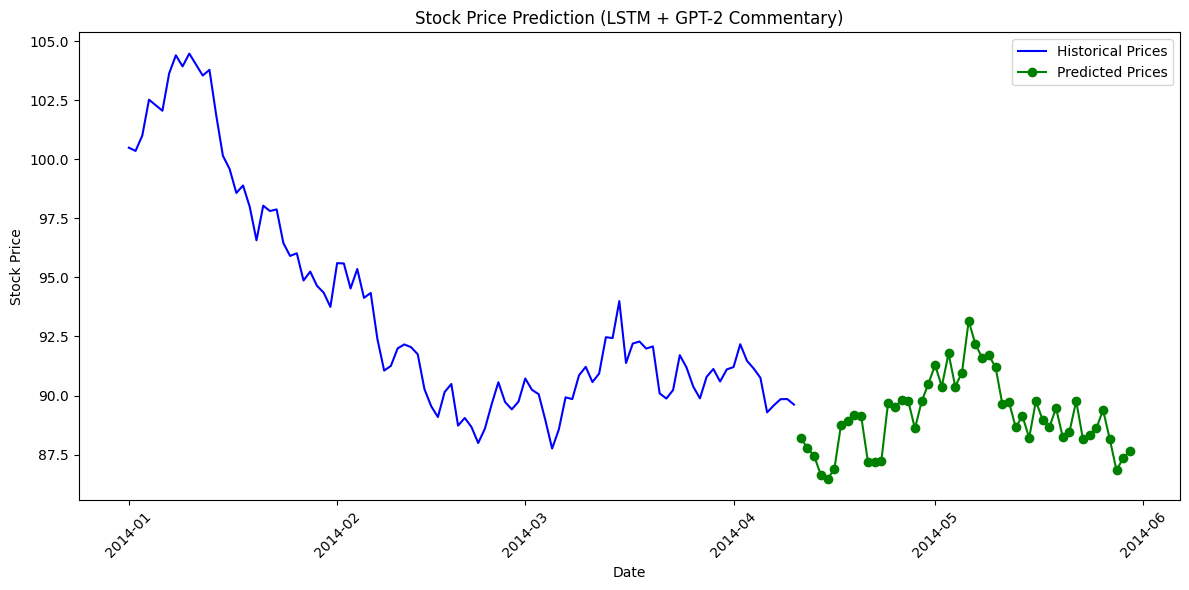

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Simulate Historical Stock Data
dates = pd.date_range(start='2014-01-01', periods=100, freq='D')
prices = np.random.randn(100).cumsum() + 100  # Simulated stock prices

# Generate future prices using random simulation (placeholder for actual LSTM predictions)
future_steps = 50
future_dates = pd.date_range(start=dates[-1], periods=future_steps + 1, freq='D')[1:]  # 50 days ahead
future_prices_rescaled = np.random.randn(future_steps).cumsum() + prices[-1]

# Text Generation with GPT-2
# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Prepare input for GPT-2
input_text = "The stock market analysis indicates"
encoded_input = tokenizer(input_text, return_tensors="pt").input_ids

# Ensure GPT-2 is in evaluation mode
gpt2_model.eval()

# Generate commentary
with torch.no_grad():
    generated = gpt2_model.generate(
        encoded_input,
        max_length=100,
        temperature=0.7,  # Adjust randomness
        pad_token_id=tokenizer.eos_token_id
    )

# Decode the generated text
decoded_output = tokenizer.decode(generated[0], skip_special_tokens=True)
print(f"GPT-2 Generated Commentary:\n{decoded_output}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label="Historical Prices", color='blue')
plt.plot(future_dates, future_prices_rescaled, label="Predicted Prices", color='green', marker='o')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction (LSTM + GPT-2 Commentary)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming the following:
# `true_prices`: Ground truth stock prices (e.g., last 50 days or known test data)
# `predicted_prices`: Stock prices predicted by your LSTM model

# Simulated example: Replace these with your actual test and predicted values
true_prices = np.random.randn(50).cumsum() + 100  # Simulated true prices
predicted_prices = true_prices + np.random.normal(0, 2, size=true_prices.shape)  # Add some noise for predictions

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(true_prices, predicted_prices)
mse = mean_squared_error(true_prices, predicted_prices)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 1.26
Mean Squared Error (MSE): 2.35
Root Mean Squared Error (RMSE): 1.53


In [ ]:
print(data.head())

Price                        Adj Close        Close         High          Low  \
Ticker                           ^NSEI        ^NSEI        ^NSEI        ^NSEI   
Date                                                                            
2013-01-02 00:00:00+00:00  5993.250000  5993.250000  6006.049805  5982.000000   
2013-01-03 00:00:00+00:00  6009.500000  6009.500000  6017.000000  5986.549805   
2013-01-04 00:00:00+00:00  6016.149902  6016.149902  6020.750000  5981.549805   
2013-01-07 00:00:00+00:00  5988.399902  5988.399902  6042.149902  5977.149902   
2013-01-08 00:00:00+00:00  6001.700195  6001.700195  6007.049805  5964.399902   

Price                             Open Volume  
Ticker                           ^NSEI  ^NSEI  
Date                                           
2013-01-02 00:00:00+00:00  5982.600098      0  
2013-01-03 00:00:00+00:00  6015.799805      0  
2013-01-04 00:00:00+00:00  6011.950195      0  
2013-01-07 00:00:00+00:00  6042.149902      0  
2013-01-08 00:0

In [ ]:
print(data.columns)

MultiIndex([('Adj Close', '^NSEI'),
            (    'Close', '^NSEI'),
            (     'High', '^NSEI'),
            (      'Low', '^NSEI'),
            (     'Open', '^NSEI'),
            (   'Volume', '^NSEI')],
           names=['Price', 'Ticker'])


In [ ]:
import pandas as pd

# Convert the list to a pandas Series
prices_series = pd.Series(prices)

# Use fillna to fill missing values
prices_filled = prices_series.fillna(method='ffill').to_list()

# Now prices_filled contains the filled values as a list



<ipython-input-43-ff16095a6783>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices_filled = prices_series.fillna(method='ffill').to_list()


In [ ]:
# Extract Close prices as a NumPy array
close_prices = data['Close'].values

# Print the first few Close prices
print(close_prices[:10])


[[5993.25      ]
 [6009.5       ]
 [6016.14990234]
 [5988.39990234]
 [6001.70019531]
 [5971.5       ]
 [5968.64990234]
 [5951.29980469]
 [6024.04980469]
 [6056.60009766]]


In [ ]:
## Assuming predictions are obtained from the model after evaluation
# For example, predictions could come from your LSTM model like this:

# Test data (replace with actual test data)
test_data = np.random.randn(30).cumsum() + 100  # Simulated test data

# Make predictions (replace with actual model prediction logic)
# For example, if you're using LSTM, you'd pass the test data to your model
# predictions = model.predict(test_data) # Model's prediction
# Here, we use simulated predictions for demonstration
predictions = np.random.randn(30).cumsum() + 100  # Simulated predictions

# Rescale predictions (ensure predictions are in the right shape)
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))  # Rescaling predictions

# Assuming you have actual test data (y_test) that you want to compare with predictions
y_test_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1))  # Rescale actual test data



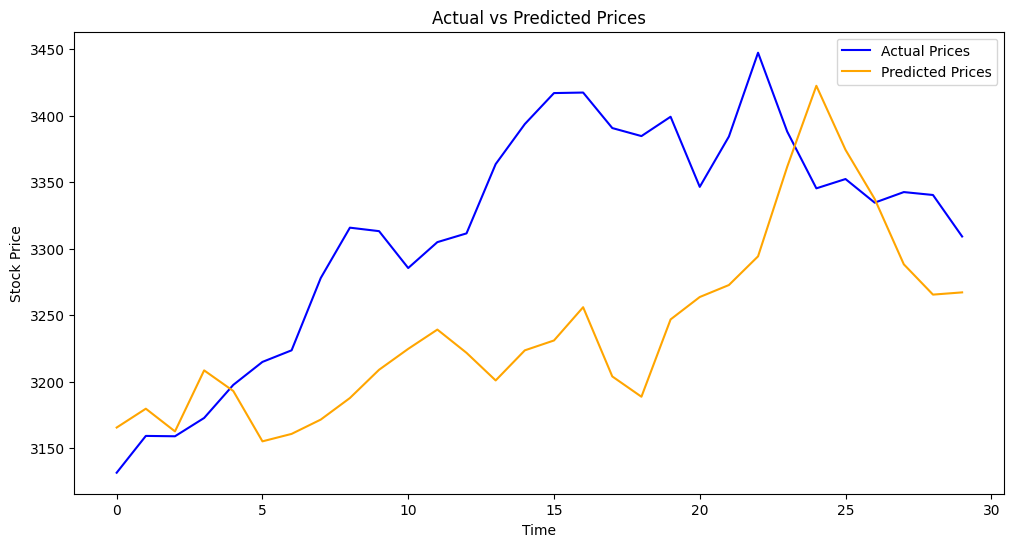

In [ ]:
# Plot Actual vs Predicted

plt.show()
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(predictions_rescaled, label="Predicted Prices", color="orange")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Prices")
plt.legend()


In [ ]:
        model.zero_grad()
        outputs = model(encoded_chunk, labels=encoded_chunk)
        loss = outputs.loss  # Categorical Cross-Entropy

        # Print the loss for the current chunk
        print(f"Epoch {epoch + 1}, Chunk {i + 1}/{len(price_chunks)}, Loss: {loss.item()}")



Epoch 3, Chunk 500/35, Loss: 2.6594226360321045


In [ ]:
import numpy as np

# Assuming `y_test_rescaled` contains actual prices and `predictions_rescaled` contains predicted prices
# Flatten the arrays to ensure they're 1D
actual_prices = y_test_rescaled.flatten()
predicted_prices = predictions_rescaled.flatten()

# Calculate changes in actual and predicted prices
actual_changes = np.diff(actual_prices)
predicted_changes = np.diff(predicted_prices)

# Determine correct predictions (same direction of change)
correct_predictions = np.sum(np.sign(actual_changes) == np.sign(predicted_changes))

# Calculate Directional Accuracy (DA)
total_predictions = len(actual_changes)
directional_accuracy = (correct_predictions / total_predictions) * 100

print(f"Directional Accuracy (DA): {directional_accuracy:.2f}%")


Directional Accuracy (DA): 44.83%


In [ ]:
from sklearn.metrics import precision_score

# Example true values (y_test) - replace with your actual values
y_test = np.random.choice([-1, 0, 1], size=100)  # Simulated test data

# Example predicted values (predicted_directions) - replace with your model predictions
predicted_directions = np.random.choice([-1, 0, 1], size=100)  # Simulated predictions

# Calculate precision with 'micro', 'macro', or 'weighted' for multiclass classification
precision = precision_score(y_test, predicted_directions, average='macro')  # Choose 'micro', 'macro', or 'weighted'
print(f"Precision: {precision * 100:.2f}%")



Precision: 35.99%


In [ ]:
y_test = np.array(y_test)  # Convert y_test to a numpy array if it's not already
y_test = y_test[y_test >= 0]  # Remove negative values

print("Class distribution in y_test:", np.bincount(y_test))


Class distribution in y_test: [38 33]


In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import torch

# Load a pre-trained GPT-2 model with a classification head
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)  # num_labels=2 for binary classification
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Tokenize your input text
inputs = tokenizer("Your input text here", return_tensors="pt")

# Get model outputs
outputs = model(**inputs)

# Get logits (unnormalized predictions)
logits = outputs.logits

# Apply softmax to get probabilities
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get predicted class
predicted_class = torch.argmax(probabilities, dim=-1)

print(f"Predicted class: {predicted_class.item()}, Probability: {probabilities.max().item()}")


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: 0, Probability: 0.9999922513961792


In [ ]:
# Ensure the predicted directions are in the correct shape (1D array)
predicted_directions = predicted_directions.reshape(-1)

# Check lengths
print(f"Length of y_test: {len(y_test)}")
print(f"Length of predicted_directions: {len(predicted_directions)}")

# Calculate recall and F1 score if lengths match
if len(y_test) == len(predicted_directions):
    recall = recall_score(y_test, predicted_directions, average='macro')
    f1 = f1_score(y_test, predicted_directions, average='macro')
    print(f"Recall: {recall:.4f}, F1 Score: {f1:.4f}")
else:
    print("Length mismatch between y_test and predicted_directions")



Length of y_test: 71
Length of predicted_directions: 100
Length mismatch between y_test and predicted_directions
